In here we tried to perform the model on lsoa level, summerzing all the sentences vectors within one lsoa, use these to predict gentrification.

In [67]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.geometry import Point
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

In [68]:
# merge the gentri label to the vectorization text
# use 'polygon' or 'wgs84_polygon', depend on what coordinate the label is
# load gentri label
lsoa_label = gpd.read_file("data/gentri_data/london_gentri_labeled_25.shp")
lsoa_label.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [69]:
stru_data = pd.read_csv("data/all_stru_data.csv")
print(lsoa_label.columns)

Index(['LSOA code', 'LSOA11NM', 'imd_score_', 'price_grow', 'high_price',
       'high_imd_i', 'gentrified', 'geometry'],
      dtype='object')


In [70]:
stru_data = stru_data.rename(columns={'LSOA Code': 'LSOA code'})
lsoa_label = lsoa_label.merge(stru_data, on= "LSOA code", how="left")

In [71]:
# use the wgs84_polygon to join the label with text
# read the text
text = pd.read_parquet("sbert_encoded_data.parquet")
print(text.columns)

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'sbert_374', 'sbert_375', 'sbert_376', 'sbert_377', 'sbert_378',
       'sbert_379', 'sbert_380', 'sbert_381', 'sbert_382', 'sbert_383'],
      dtype='object', length=401)


In [72]:
# turn polygon coordinate into shapely 
# make sure to drop the null geodata
text_valid = text[text['wgs84_polygon.coordinates'].notnull()].copy()
text_valid["geometry"] = text_valid["wgs84_polygon.coordinates"].apply(lambda coords: Polygon(coords[0]))
# creat GeoDataFrame， set WGS84 coordinate
gdf_text = gpd.GeoDataFrame(text_valid, geometry="geometry", crs="EPSG:4326")

In [73]:
# set to 27700
gdf_27700 = gdf_text.to_crs("EPSG:27700")

In [74]:
joined = gpd.sjoin(gdf_27700, lsoa_label[["LSOA code", "geometry", "high_price", "gentrified", "pop_growth_rate", 
                                          "price_grow", "avg_den", "senior_per", "minority_per"]], 
                                          how="left", predicate="within")

In [75]:
# get the centroid of each polygon
gdf_27700["centroid"] = gdf_27700.geometry.centroid

In [76]:
# spatial join
joined_centroid = gpd.sjoin(gdf_27700.set_geometry("centroid"), lsoa_label[["LSOA code", "geometry", "high_price", "gentrified", "pop_growth_rate", 
                                                                            "price_grow", "avg_den", "senior_per", "minority_per"]],
                                                                            how="left",predicate="within")

In [77]:
joined_cleaned = joined_centroid[joined_centroid["gentrified"].notna()].copy()
joined_cleaned.columns

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'centroid', 'index_right', 'LSOA code', 'high_price', 'gentrified',
       'pop_growth_rate', 'price_grow', 'avg_den', 'senior_per',
       'minority_per'],
      dtype='object', length=412)

In [78]:
# 按 LSOA 编码分组，取均值（你也可以试试 sum、max 等方式）
sbert_cols = [f"sbert_{i}" for i in range(384)]
lsoa_vecs = joined_cleaned.groupby("LSOA code")[sbert_cols].mean()

# struct_cols = ['pop_growth_rate', 'avg_den', 'senior_per', 'minority_per']
# lsoa_struct = joined_cleaned.groupby("LSOA code")[struct_cols].mean()

# lsoa_combined = lsoa_vecs.join(lsoa_struct, how='left')

# lsoa_label = joined_cleaned[['LSOA code', 'gentrified']].drop_duplicates()
# lsoa_combined = lsoa_combined.reset_index().merge(lsoa_label, on="LSOA code", how="left")


In [79]:
anchor_dict = {
    "residential": ["flat conversion", "refurbishment", "rear extension", "self contained", "flats", "single storey", "storey rear extension"],
    "commercial": ["coffee shop", "illuminated sign", "retail unit upgrade", "use class", "change use"],
    "green": ["park improvement", "landscaping", "tree planting"],
    "cultural": ["artist studios", "cultural space", "gallery conversion"],
    "infrustructure": ["station upgrade", "utilities improvement", "internally illuminated", "ground floor level", "floor level"]
}
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
# 正确计算平均向量：
anchor_vecs = {
    k: np.mean(sbert_model.encode(v), axis=0) for k, v in anchor_dict.items()
}

In [80]:
# from sklearn.metrics.pairwise import cosine_similarity

# # 示例：一列句子向量 (shape: N x 384)，和 5 个 anchor (5 x 384)
# sent_vecs = lsoa_combined[[f"sbert_{i}" for i in range(384)]].values
# anchor_vecs_matrix = np.vstack([anchor_vecs[a] for a in anchor_dict])  # shape: 5 x 384

# # 计算所有句子对所有 anchor 的相似度
# sim_matrix = cosine_similarity(sent_vecs, anchor_vecs_matrix)  # shape: N x 5

# # 加入列名
# sim_df = pd.DataFrame(sim_matrix, columns=[f"sim_{a}" for a in anchor_dict])
# lsoa_combined = pd.concat([lsoa_combined.reset_index(drop=True), sim_df], axis=1)


In [81]:
# print(lsoa_combined.shape)

In [82]:
# features = ['pop_growth_rate', 'avg_den', 'senior_per','minority_per', 
#             'sim_residential', 'sim_commercial', 'sim_green', 'sim_cultural', 'sim_infrustructure']
# lsoa_combined['gentrified'] = lsoa_combined['gentrified'].astype(int)

# X = lsoa_combined[features]
# y = lsoa_combined['gentrified']

# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.metrics import classification_report

# # 样本不均衡处理
# scale_pos_weight = (y == 0).sum() / (y == 1).sum()

# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
# model.fit(X_train, y_train)

# print(classification_report(y_test, model.predict(X_test)))

In [83]:
# print(scale_pos_weight)

In [84]:
# X_base = lsoa_combined[struct_cols]
# y_base = lsoa_combined['gentrified']

# X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, stratify=y_base, test_size=0.2, random_state=42)

# model_base = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
# model_base.fit(X_base_train, y_base_train)

# print(classification_report(y_base_test, model_base.predict(X_base_test)))

In [85]:
# # feature importance
# from xgboost import plot_importance

# plt.figure(figsize=(10, 6))
# plot_importance(model, importance_type='gain', max_num_features=10)
# plt.title("Top 10 Important Features (by Gain)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [86]:
def extract_diverse_anchor_sentences(
    anchor_vecs,           # 你的人工定义 anchor 向量: {anchor_name: vector}
    all_sentences,         # 句子列表: List[str]
    sbert_model,           # SentenceTransformer 模型
    topk,               # 每个 anchor 最多考虑 topk 相似句子作为候选
    anchor_threshold,  # anchor 与句子相似度下限
    sim_threshold     # 被选句子之间最大相似度（越小越多样）
):
    # 编码所有句子为向量
    print("emcoding all sentences...")
    sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

    anchor_top_sentences = {}

    for cat, anchor_vec in tqdm(anchor_vecs.items(), desc="🔍 extract sentences from each category"):
        sims = cosine_similarity([anchor_vec], sent_vecs)[0]

        # 找出相似度高于 anchor_threshold 的 topk 句子
        sorted_idx = np.argsort(sims)[::-1]
        filtered_idx = [i for i in sorted_idx if sims[i] >= anchor_threshold][:topk]

        selected = []
        selected_vecs = []

        for i in filtered_idx:
            sent = all_sentences[i]
            vec = sent_vecs[i]

            # 判断与已选句子的相似度是否都低于 sim_threshold
            if all(cosine_similarity([vec], [v])[0][0] < sim_threshold for v in selected_vecs):
                selected.append({"sentence": sent, "score": float(sims[i])})
                selected_vecs.append(vec)

        anchor_top_sentences[cat] = selected
        print(f"✅ {cat}: select {len(selected)} sentences")

    return anchor_top_sentences

In [ ]:
# 强制转成字符串 & 去除缺失值
all_sentences = joined_cleaned['sentences'].dropna().astype(str).tolist()

In [89]:
diverse_results = extract_diverse_anchor_sentences(
    anchor_vecs=anchor_vecs,
    all_sentences=all_sentences ,
    sbert_model=sbert_model,
    topk=50,
    anchor_threshold=0.5,
    sim_threshold=0.7
)

emcoding all sentences...


Batches:   0%|          | 0/4856 [00:00<?, ?it/s]

🔍 extract sentences from each category:  20%|██        | 1/5 [00:00<00:00,  4.19it/s]

✅ residential: select 1 sentences
✅ commercial: select 5 sentences


🔍 extract sentences from each category:  60%|██████    | 3/5 [00:00<00:00,  3.71it/s]

✅ green: select 7 sentences
✅ cultural: select 10 sentences


🔍 extract sentences from each category: 100%|██████████| 5/5 [00:01<00:00,  4.15it/s]

✅ infrustructure: select 14 sentences


In [91]:
def get_anchor_vecs_from_diverse_results(diverse_results, sbert_model):
    anchor_vecs = {}
    for cat, items in diverse_results.items():
        sentences = [entry["sentence"] for entry in items]
        vecs = sbert_model.encode(sentences, batch_size=32)
        anchor_vecs[cat] = vecs.mean(axis=0)  # 平均向量作为 anchor
    return anchor_vecs

In [92]:
# 获取平均向量组成的 anchor
keyline_vecs = get_anchor_vecs_from_diverse_results(diverse_results, sbert_model)

In [93]:
def score_sentences_against_anchors(anchor_vecs, all_sentences, sbert_model):
    
    print("encoding all sentences...")
    sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

    scores = {}

    for cat, anchor_vec in anchor_vecs.items():
        sims = cosine_similarity([anchor_vec], sent_vecs)[0]  # shape: (num_sentences,)
        scores[cat] = sims

    # 合成 DataFrame
    import pandas as pd
    score_df = pd.DataFrame(scores)
    score_df['sentence'] = all_sentences

    return score_df

In [94]:
# 调用函数
score_df = score_sentences_against_anchors(
    anchor_vecs=keyline_vecs,
    all_sentences=all_sentences,
    sbert_model=sbert_model
)

encoding all sentences...


Batches:   0%|          | 0/4856 [00:00<?, ?it/s]

In [ ]:
# # 加上 LSOA code（确保顺序匹配）
# score_df['LSOA code'] = joined_cleaned['LSOA code'].values

# # 只保留数值列（通常是 anchor 类别的列）
# anchor_score_numeric = score_df.select_dtypes(include='number')

# # 添加 LSOA code 回来做分组
# anchor_score_numeric['LSOA code'] = score_df['LSOA code']

# # 按 LSOA 聚合 anchor 得分（均值）
# anchor_lsoa = anchor_score_numeric.groupby('LSOA code').mean().reset_index()


In [207]:
import pandas as pd

# 设置你要保留的 anchor 列和 top-N 值
anchor_cols = ['residential', 'commercial', 'green', 'cultural', 'infrustructure']
top_n = 5  # 每个 LSOA 只保留相似度最高的 5 条句子

# 确保 score_df 里有 'LSOA code' 和 anchor 得分
score_df['LSOA code'] = joined_cleaned['LSOA code'].values

# 定义函数：对每个 LSOA, anchor 取 top-N 后聚合
def top_n_mean(df, anchor, n=5):
    return (
        df.sort_values(by=anchor, ascending=False)
          .head(n)[anchor]
          .mean()
    )

# 建立结果 DataFrame
lsoa_list = score_df['LSOA code'].unique()
topn_dict = {'LSOA code': []}
for anchor in anchor_cols:
    topn_dict[anchor + '_topn_mean'] = []

# 遍历每个 LSOA 和 anchor 聚合
for lsoa in lsoa_list:
    topn_dict['LSOA code'].append(lsoa)
    lsoa_df = score_df[score_df['LSOA code'] == lsoa]
    for anchor in anchor_cols:
        val = top_n_mean(lsoa_df, anchor, n=top_n)
        topn_dict[anchor + '_topn_mean'].append(val)

# 转为 DataFrame
anchor_lsoa_topn = pd.DataFrame(topn_dict)

In [161]:
print(anchor_lsoa_topn.head(5))

   LSOA code  residential_topn_mean  commercial_topn_mean  green_topn_mean  \
0  E01002714               0.760136              0.689529         0.700867   
1  E01002771               0.781176              0.581556         0.683054   
2  E01000220               0.906424              0.508664         0.511596   
3  E01001220               0.669778              0.600520         0.555940   
4  E01003187               0.349043              0.578166         0.357311   

   cultural_topn_mean  infrustructure_topn_mean  
0            0.580095                  0.756108  
1            0.564128                  0.699904  
2            0.580305                  0.633844  
3            0.555096                  0.644365  
4            0.474421                  0.488227  


In [163]:
# 把结构变量也合并进来（你之前好像从 lsoa_label 或其他来源获得）
final_df = pd.merge(anchor_lsoa_topn, lsoa_label[['LSOA code', 'gentrified', 
                                             'avg_den', 'pop_growth_rate', 'senior_per', 'minority_per']], 
                                             on='LSOA code')

In [182]:
print(final_df.shape)

(4271, 11)


In [222]:
final_df.to_csv("lsoa_model_dataframe.csv", index=False)

In [223]:
features = ['pop_growth_rate', 'avg_den', 'senior_per', 'minority_per', 
            'residential_topn_mean', 'commercial_topn_mean', 
            'green_topn_mean', 'cultural_topn_mean', 'infrustructure_topn_mean']
final_df['gentrified'] = final_df['gentrified'].astype(int)

X = final_df[features]
y = final_df['gentrified']

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report


# 样本不均衡处理
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y, 
                                                    test_size=0.25, 
                                                    random_state=42)

scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

model = XGBClassifier(scale_pos_weight = scale_pos_weight,
                      random_state=42, 
                      eval_metric="aucpr")

model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score, average_precision_score

y_proba = model.predict_proba(X_test)[:, 1]  # 取预测为 1 的概率
print("AUROC:", roc_auc_score(y_test, y_proba))
print("AUPRC:", average_precision_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.95      0.98      0.96      1008
           1       0.17      0.08      0.11        60

    accuracy                           0.93      1068
   macro avg       0.56      0.53      0.54      1068
weighted avg       0.90      0.93      0.91      1068

AUROC: 0.6272652116402118
AUPRC: 0.09806154371254769


In [224]:
print(scale_pos_weight)

16.794444444444444


In [225]:
base = ['pop_growth_rate', 'avg_den', 'senior_per','minority_per']

X_base = final_df[base]
y_base = final_df['gentrified']

X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(X_base, y_base, 
                                                                        stratify=y_base, 
                                                                        test_size=0.25, 
                                                                        random_state=42)

model_base = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42)
model_base.fit(X_base_train, y_base_train)

y_base_pred = model_base.predict(X_base_test)

print(classification_report(y_base_test, y_base_pred))

y_base_proba = model_base.predict_proba(X_base_test)[:, 1]  # 取预测为 1 的概率
print("AUROC:", roc_auc_score(y_base_test, y_base_proba))
print("AUPRC:", average_precision_score(y_base_test, y_base_proba))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1008
           1       0.04      0.03      0.04        60

    accuracy                           0.90      1068
   macro avg       0.49      0.49      0.49      1068
weighted avg       0.89      0.90      0.90      1068

AUROC: 0.5544808201058201
AUPRC: 0.07328960651049135


In [226]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import make_scorer, classification_report, f1_score
import numpy as np

# 1. 特征与标签
X = final_df[features]
y = final_df['gentrified'].astype(int)

# 2. 创建 pipeline：undersampling + XGBoost

pipeline = Pipeline([
    ("undersample", RandomUnderSampler(random_state=42)),
    ("clf", XGBClassifier(scale_pos_weight=1,  # 不需要 scale_pos_weight，因为已经下采样
                          random_state=42, 
                          eval_metric="aucpr"))
])

# 3. Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 4. 交叉验证评估：使用 F1-score（重点关注 minority class）
scores = cross_val_score(pipeline, X, y, 
                         scoring=make_scorer(f1_score, pos_label=1), 
                         cv=cv)

print("F1 score for minority class (gentrified=1) across 5 folds:")
print("Scores:", np.round(scores, 4))
print("Mean F1 score:", np.round(scores.mean(), 4))

F1 score for minority class (gentrified=1) across 5 folds:
Scores: [0.1128 0.1409 0.1304 0.1241 0.1429]
Mean F1 score: 0.1302


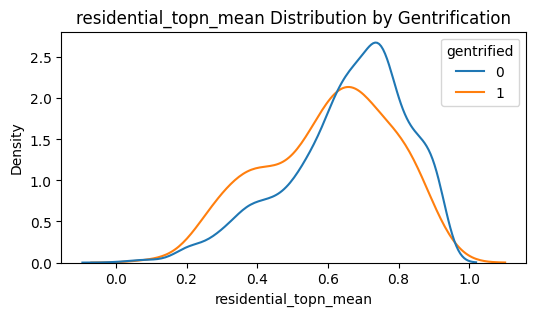

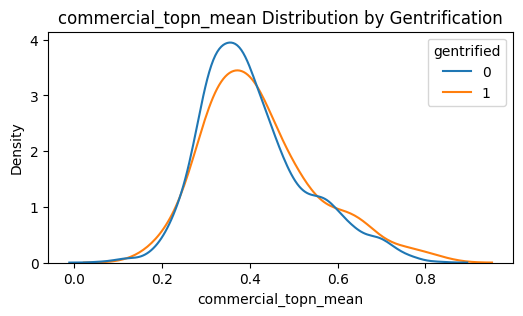

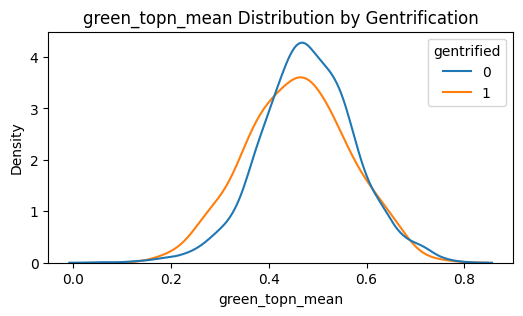

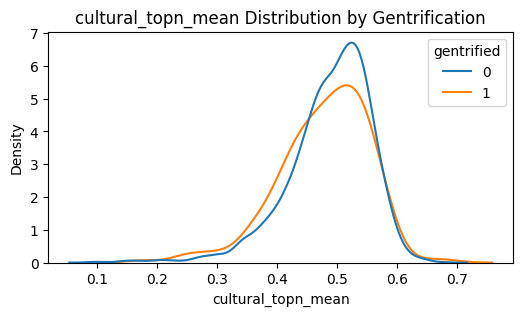

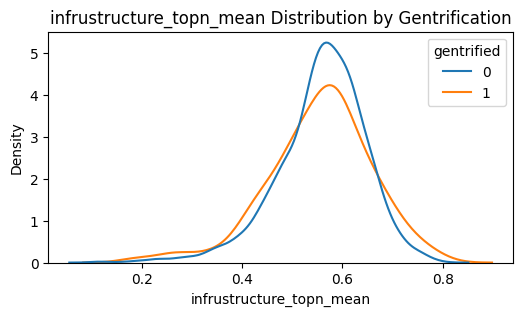

In [227]:
anchor_cols = ['residential_topn_mean', 'commercial_topn_mean', 'green_topn_mean', 'cultural_topn_mean', 'infrustructure_topn_mean']

for col in anchor_cols:
    plt.figure(figsize=(6, 3))
    sns.kdeplot(data=final_df, x=col, hue='gentrified', common_norm=False)
    plt.title(f"{col} Distribution by Gentrification")
    plt.show()

In [228]:
X = final_df[features]
y = final_df['gentrified']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(X_resampled, y_resampled, 
                                                                                            stratify=y_resampled, 
                                                                                            test_size=0.25, 
                                                                                            random_state=42)

scale_pos_weight = len(y_resampled_train[y_resampled_train == 0]) / len(y_resampled_train[y_resampled_train == 1])

model_resampled = XGBClassifier(scale_pos_weight = scale_pos_weight,
                      random_state=42, 
                      eval_metric="aucpr")

model_resampled.fit(X_resampled_train, y_resampled_train)

# Evaluate
y_resampled_pred = model_resampled.predict(X_resampled_test)
print(classification_report(y_resampled_test, y_resampled_pred))
y_resampled_proba = model_resampled.predict_proba(X_resampled_test)[:, 1]  # 取预测为 1 的概率
print("AUROC:", roc_auc_score(y_resampled_test, y_resampled_proba))
print("AUPRC:", average_precision_score(y_resampled_test, y_resampled_proba))


              precision    recall  f1-score   support

           0       0.53      0.48      0.50        60
           1       0.52      0.57      0.54        60

    accuracy                           0.53       120
   macro avg       0.53      0.53      0.52       120
weighted avg       0.53      0.53      0.52       120

AUROC: 0.5900000000000001
AUPRC: 0.6494055326948425


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

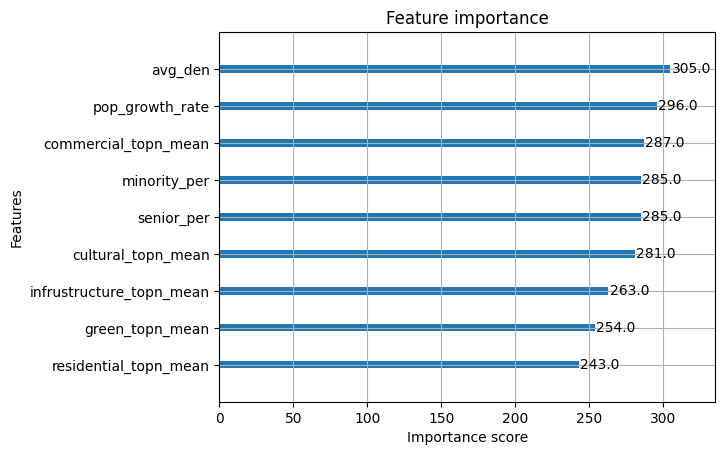

In [229]:
from xgboost import plot_importance
plot_importance(model)

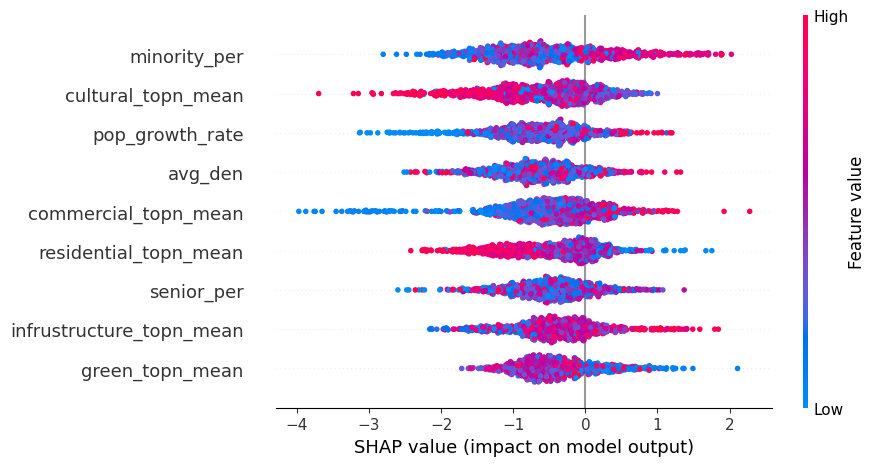

In [230]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.plots.beeswarm(shap_values)

# 2020-2022 date predict

In [ ]:
text_20_22 = pd.read_csv("data/cleaned_projects_20_22.csv")
print(text_20_22)

                                                site_name decision_date  \
0              70 Chingford Lane, Woodford Green, IG8 9QP    2020-08-20   
1         174 ELTHAM PALACE ROAD, ELTHAM, LONDON, SE9 5LZ    2021-01-25   
2                                          Berkeley Hotel    2020-09-16   
3                                       38 Clarendon Road    2020-03-16   
4                    1 Phillimore Gardens, LONDON, W8 7QB    2020-02-26   
...                                                   ...           ...   
377932                  18 Pasture Road, Wembley, HA0 3JL    2022-10-14   
377933  1 GABLE COURT, LAWRIE PARK AVENUE, LONDON, SE2...    2022-07-29   
377934                19 HASELTINE ROAD, LONDON, SE26 5AF    2022-11-07   
377935             11 HATCHAM PARK ROAD, LONDON, SE14 5QE    2022-12-20   
377936                 9 GILLIAN STREET, LONDON, SE13 7AH    2022-08-08   

        valid_date  polygon  wgs84_polygon  \
0       2020-06-18      NaN            NaN   
1      

In [211]:
print(text_20_22.columns)
print(text_20_22.shape)

Index(['site_name', 'decision_date', 'valid_date', 'polygon', 'wgs84_polygon',
       'description', 'borough', 'street_name', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'polygon.coordinates', 'total_no_proposed_residential_units',
       'total_no_existing_residential_units', 'year'],
      dtype='object')
(377937, 16)


In [215]:
from nltk.tokenize import sent_tokenize

# 1. 过滤非空 description
df = text_20_22[text_20_22['description'].notna()]

# 2. 清洗多余空格
df['description'] = df['description'].str.replace(r'\s+', ' ', regex=True).str.strip()

# 3. 拆分为句子
df['sentences'] = df['description'].apply(sent_tokenize)

# 4. 扁平化为句子列表
all_sentences_20_22 = df['sentences'].explode().tolist()

# 5. 编码
sentence_vecs_20_21 = sbert_model.encode(all_sentences_20_22, show_progress_bar=True, batch_size=32, normalize_embeddings=True)


C:\Users\hp\AppData\Local\Temp\ipykernel_26428\660742282.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['description'] = df['description'].str.replace(r'\s+', ' ', regex=True).str.strip()
C:\Users\hp\AppData\Local\Temp\ipykernel_26428\660742282.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentences'] = df['description'].apply(sent_tokenize)


Batches:   0%|          | 0/16690 [00:00<?, ?it/s]

In [217]:
print(sentence_vecs_20_21)

[[ 0.01940223  0.03690727  0.0516975  ...  0.0854616  -0.07941346
   0.09492489]
 [ 0.09131704  0.10588595 -0.0370209  ...  0.06355461 -0.01434372
   0.03977465]
 [ 0.04956537  0.01671983  0.0417967  ... -0.00717712 -0.11581879
   0.08445853]
 ...
 [ 0.01887811 -0.0197279  -0.08487949 ...  0.06749901 -0.00392187
  -0.02950815]
 [ 0.03548932  0.06495357  0.0568113  ...  0.05453596 -0.11871392
   0.06253339]
 [-0.06827552  0.01788292 -0.06481215 ...  0.05593273 -0.07074989
  -0.05511694]]


In [ ]:
# DataFrame + merge back to main list
vec_df = pd.DataFrame(sentence_vecs_20_21)
vec_df.columns = [f'sbert_{i}' for i in range(vec_df.shape[1])]
df_vectors = pd.concat([df.reset_index(drop=True), vec_df], axis=1)
print(df_vectors.head())

                                         site_name decision_date  valid_date  \
0       70 Chingford Lane, Woodford Green, IG8 9QP    2020-08-20  2020-06-18   
1  174 ELTHAM PALACE ROAD, ELTHAM, LONDON, SE9 5LZ    2021-01-25  2020-12-17   
2                                   Berkeley Hotel    2020-09-16  2020-03-04   
3                                38 Clarendon Road    2020-03-16  2020-01-16   
4             1 Phillimore Gardens, LONDON, W8 7QB    2020-02-26  2020-01-13   

   polygon  wgs84_polygon                                        description  \
0      NaN            NaN  Construction of ground floor and first floor r...   
1      NaN            NaN  Prior Approval for the construction of a singl...   
2      NaN            NaN  Samples of facing materials; details of typica...   
3      NaN            NaN  Construction of a single storey detached outbu...   
4      NaN            NaN  Installation of Air Conditioning unit at south...   

                  borough     street_n

In [221]:
df_vectors.to_parquet('sbert_encoded_data_22.parquet')

In [237]:
lsoa_label_22 = gpd.read_file("data/gentri_data/all_stru_data_20_22.shp")
lsoa_label_22.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [2]:
text_22 = pd.read_parquet("sbert_encoded_data_22.parquet")
print(text_22.columns)

NameError: name 'pd' is not defined

In [233]:
import json

def safe_parse_polygon(coord_str):
    try:
        # 将字符串解析为嵌套列表
        coords = json.loads(coord_str) if isinstance(coord_str, str) else coord_str
        return Polygon(coords[0])
    except Exception as e:
        return None

# 筛选有坐标和描述的数据
text_valid_22 = text_22[
    text_22['wgs84_polygon.coordinates'].notnull() &
    text_22['description'].notnull()
].copy()

# 构建 geometry 列
text_valid_22['geometry'] = text_valid_22['wgs84_polygon.coordinates'].apply(safe_parse_polygon)

# 删除构建失败的
text_valid_22 = text_valid_22[text_valid_22['geometry'].notnull()]

# 构建 GeoDataFrame
import geopandas as gpd
gdf_text_22 = gpd.GeoDataFrame(text_valid_22, geometry='geometry', crs='EPSG:4326')

# ✅ 验证 description 保留
print(gdf_text_22['description'].dropna().head(3))

1    Prior Approval for the construction of a singl...
2    Samples of facing materials; details of typica...
3    Construction of a single storey detached outbu...
Name: description, dtype: object


In [234]:
gdf_27700_22 = gdf_text_22.to_crs("EPSG:27700")

In [235]:
# get the centroid of each polygon
gdf_27700_22["centroid"] = gdf_27700_22.geometry.centroid

In [ ]:
joined_centroid_22 = gpd.sjoin(gdf_27700_22.set_geometry("centroid"), lsoa_label_22, how="left",predicate="within")
all_sentences_22 = joined_centroid_22['sentences'].dropna().astype(str).tolist()

MemoryError: Unable to allocate 451. MiB for an array with shape (384, 308122) and data type float32

In [ ]:
diverse_results_22 = extract_diverse_anchor_sentences(
    anchor_vecs=anchor_vecs,
    all_sentences=all_sentences_22 ,
    sbert_model=sbert_model,
    topk=50,
    anchor_threshold=0.5,
    sim_threshold=0.7
)

In [ ]:
keyline_vecs_22 = get_anchor_vecs_from_diverse_results(diverse_results_22, sbert_model)

In [ ]:
# 调用函数
score_df_22 = score_sentences_against_anchors(
    anchor_vecs=keyline_vecs_22,
    all_sentences=all_sentences_22,
    sbert_model=sbert_model
)

In [ ]:
# 加上 LSOA code（确保顺序匹配）
score_df_22['LSOA 2021'] = joined_centroid_22['LSOA 2021'].values

# 只保留数值列（通常是 anchor 类别的列）
anchor_score_numeric = score_df_22.select_dtypes(include='number')

# 添加 LSOA code 回来做分组
anchor_score_numeric['LSOA 2021'] = score_df_22['LSOA 2021']

# 按 LSOA 聚合 anchor 得分（均值）
anchor_lsoa_22 = anchor_score_numeric.groupby('LSOA 2021').mean().reset_index()

In [ ]:
# 设置你要保留的 anchor 列和 top-N 值
anchor_cols = ['residential', 'commercial', 'green', 'cultural', 'infrustructure']
top_n = 5  # 每个 LSOA 只保留相似度最高的 5 条句子

# 确保 score_df 里有 'LSOA code' 和 anchor 得分
score_df_22['LSOA 2021'] = joined_centroid_22['LSOA 2021'].values

# 定义函数：对每个 LSOA, anchor 取 top-N 后聚合
def top_n_mean(df, anchor, n=5):
    return (
        df.sort_values(by=anchor, ascending=False)
          .head(n)[anchor]
          .mean()
    )

# 建立结果 DataFrame
lsoa_list = score_df_22['LSOA 2021'].unique()
topn_dict = {'LSOA 2021': []}
for anchor in anchor_cols:
    topn_dict[anchor + '_topn_mean'] = []

# 遍历每个 LSOA 和 anchor 聚合
for lsoa in lsoa_list:
    topn_dict['LSOA 2021'].append(lsoa)
    lsoa_df = score_df_22[score_df_22['LSOA 2021'] == lsoa]
    for anchor in anchor_cols:
        val = top_n_mean(lsoa_df, anchor, n=top_n)
        topn_dict[anchor + '_topn_mean'].append(val)

# 转为 DataFrame
anchor_lsoa_topn_22 = pd.DataFrame(topn_dict)

In [ ]:
# 把结构变量也合并进来（你之前好像从 lsoa_label 或其他来源获得）
final_df_22 = pd.merge(anchor_lsoa_topn_22, lsoa_label_22[['LSOA 2021', 
                                             'avg_den', 'pop_growth', 'senior_per', 'minority_p']], 
                                             on='LSOA 2021', how="left")
final_df_22 = final_df_22.dropna()

In [ ]:
from sklearn.impute import SimpleImputer

feature_cols_22 = ['avg_den', 'pop_growth', 'senior_per', 'minority_p',
                   'residential_topn_mean', 'commercial_topn_mean', 
                   'green_topn_mean', 'cultural_topn_mean','infrustructure_topn_mean',]
X_2020 = final_df_22[feature_cols_22].copy()

imputer = SimpleImputer(strategy='mean')
X_2020_imputed = imputer.fit_transform(X_2020)

feature_cols_22['gentri_prob'] = model.predict_proba(X_2020_imputed)[:, 1]

threshold = 0.6  # 可调节
final_df_22['gentri_pred'] = (final_df_22['gentri_prob'] >= threshold).astype(int)


KeyboardInterrupt: 

In [ ]:
gdf_2020 = lsoa_label_22.merge(final_df_22[['LSOA 2021', 'gentri_prob']], on='LSOA 2021')

gdf_2020.plot(column='gentri_prob', cmap='OrRd', legend=True, figsize=(12, 8))
plt.title("Predicted Gentrification Probability (2020–2022)")
plt.axis('off')
plt.show()

In [ ]:
high_risk = final_df_22[final_df_22['gentri_prob'] > 0.8]
print("高潜在绅士化区域数：", len(high_risk))
display(high_risk[['LSOA 2021', 'gentri_prob']].sort_values('gentri_prob', ascending=False).head(10))